### Preamble

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import pandas as pd
import warnings
from matplotlib import cm
from lmfit.models import ConstantModel, StepModel
from matplotlib.cbook import contiguous_regions
from scipy.stats import ttest_ind
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd
import scipy.stats as stats
import IPython
warnings.filterwarnings('ignore')

### Generate synthetic data

We'll generate synthetic data with positive steps that have some gaussian noise to demonstrate the ease of use of this notebook

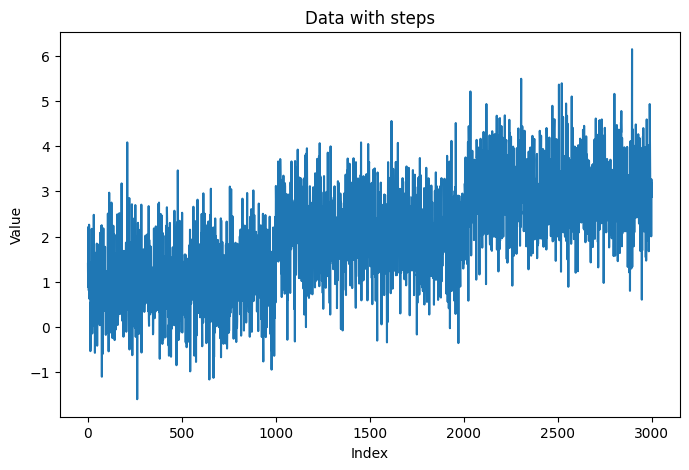

In [2]:
# Parameters
n_points = 3000  # total number of data points
noise_std = 0.8  # standard deviation of Gaussian noise
np.random.seed(42) # to reproduce the results

# Generate step-wise data with three positive steps
steps = [(0, 1000, 1.0), (1000, 2000, 2.0), (2000, 3000, 3.0)]  # (start, end, value)

data = np.zeros(n_points)
for start, end, value in steps:
    data[start:end] = value

# Add Gaussian noise
noise = np.random.normal(0, noise_std, n_points)
noisy_data = data + noise

# Create x-axis
x = np.arange(n_points)

# Visualization using matplotlib
plt.figure(figsize=(8, 5))
plt.plot(x, noisy_data)
plt.title("Data with steps")
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

$\textbf{Fig 1}$. A simple synthetic data with three steps, gaussian noise added to resemble real data.

In [3]:
tracename='test_trace_1'
trace=noisy_data

Trace is:3000 pts long
Time end point: 3000.00, 3000.00


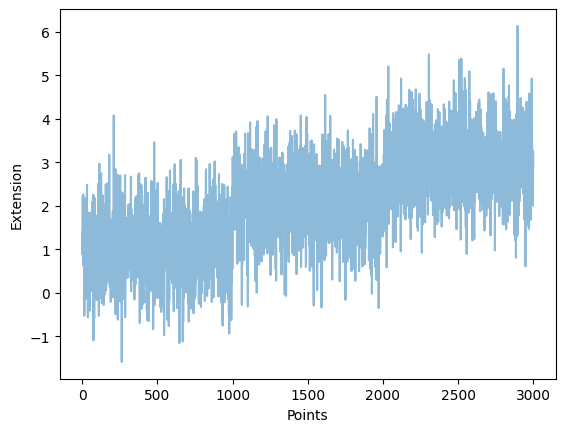

In [4]:
# x vals
len_trace = len(trace)
print(f'Trace is:{len_trace} pts long')

# time trace
time_trace = np.linspace(0,len_trace,len_trace)
print(f'Time end point: {len_trace:.2f}, {time_trace[-1]:.2f}')

plt.plot(time_trace,trace,alpha=0.5)
plt.xlabel('Points')
plt.ylabel('Extension')
plt.show()

$\textbf{Fig 2}.$ The data could be some extension over time plot. Here the x-axis is just the data indices.

Below, `window_length` is an important parameter in the fits. I call all these parameters below - hyperparameters.

In [5]:
# trace parameters
dt=1 # data frequency (1/fps)
window_length = int(0.02*len_trace)
print(f'window length: {window_length}')
method='ttest' # step determination method (currently only has t-test)

# if small steps are being picked up you can tune these values as well
min_threshold=0.05 # declares the p-value that qualifies a 'null' region, not a step
max_threshold=0.005 # once a p-value crosses this threshold, it is counted as a step
exclusion = 0.4 # steps must be larger than this value

window length: 60


In [6]:
# save the hyperparameters
df_hyperparams = pd.DataFrame()
np.savetxt(f'input_params_{tracename}',(dt,window_length,min_threshold,max_threshold,exclusion),header='dt,window_length,min_threshold,max_threshold,exclusion')

### Do t-test first

In [7]:
# get the sliding windows
a = np.lib.stride_tricks.sliding_window_view(trace, window_length)[:-1]
a.shape

(2940, 60)

T-test

2880


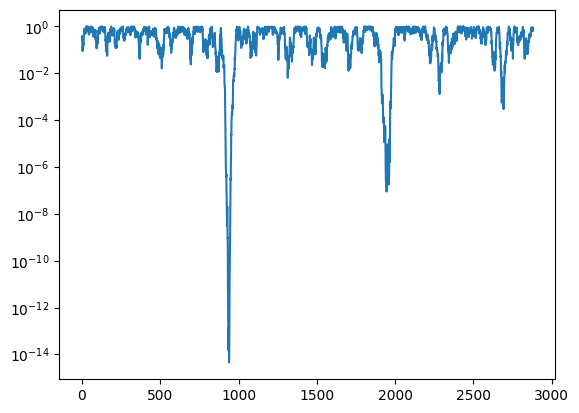

In [8]:
tscore, pvalue = ttest_ind(a[window_length:].T, a[:-window_length].T)
print(len(pvalue))
plt.semilogy(pvalue)
plt.show()

$\textbf{Fig 3}.$ Plot of the p-values.

### Do step fitting

In [9]:
# mark regions with p values less than the threshold
regions = contiguous_regions(pvalue < min_threshold)
len(regions)

48

In [10]:
# Filter out regions that are shorter than window_length
msk = np.ravel(np.diff(regions) >= window_length)          # 1-> Determines separation between                                                                     
regions = np.array(regions)[msk]                           # 2-> Applies mask to regions array and reassigns to eliminate masked values from the array

# Filter out regions with no pvalues greater than max_threshold            
regions = np.array([r for r in regions if any(
    pvalue[slice(*r)] < max_threshold)])

# Create loose threshold for amplitude difference between regions
c_list = []      # c = array of filtered regions

for i in regions:
    # for positive steps
    if np.mean(trace[i[1]:(i[1]+window_length)])-np.mean(trace[(i[0]-window_length):i[0]]) > exclusion:
    
    # for negative steps
    # if np.mean(trace[i[1]:(i[1]+window_length)])-np.mean(trace[(i[0]-window_length):i[0]]) <- exclusion:
    # Basic threshold filter by user-defined value
        d = np.array([i[0],i[1]])
        c_list.append(d)

In [11]:
# create a model
model = ConstantModel()
params=model.make_params(c=trace[:10].mean())
params

name,value,initial value,min,max,vary
c,1.35844889,1.358448889359005,-inf,inf,True


In [12]:
#############################################################
### Give estimates for parameters so LMfit can do its job ###
#############################################################
# new regions
regions=np.array(c_list)
count = 0

for i, r in enumerate(regions): # Creates a counter in 'i' and uses it as an index for 
                                        # the items 'r'; example: https://www.geeksforgeeks.org/enumerate-in-python/
    stime = time_trace[slice(*r)]
    strace = trace[slice(*r)]
    xmax, xmin = max(stime), min(stime)
    ymax, ymin = max(strace), min(strace)
    sigma = (xmax-xmin)/2
    step = StepModel(prefix=f"s{i}_")
    # print(step)
    # amplitude of the step
    params.add(f"s{i}_amplitude", value=ymax-ymin)
    # center is center of the step
    params.add(f"s{i}_center", value=xmin + sigma)
    # sigma is the width
    params.add(f"s{i}_sigma", value=sigma, min=0, max=2*sigma)
    # add in the step in this contigous model
    model += step

    # number of models I think
    count += 1
    print(count)
output = model.fit(trace, params, x = time_trace, maxiter=50000)
print(f'Steps fitted: {count}')

1
2
Steps fitted: 2


### Print results

In [13]:
output

$\textbf{amplitude = height of a step, center = center location of a step, sigma = width of a step}$

### Visualize the output

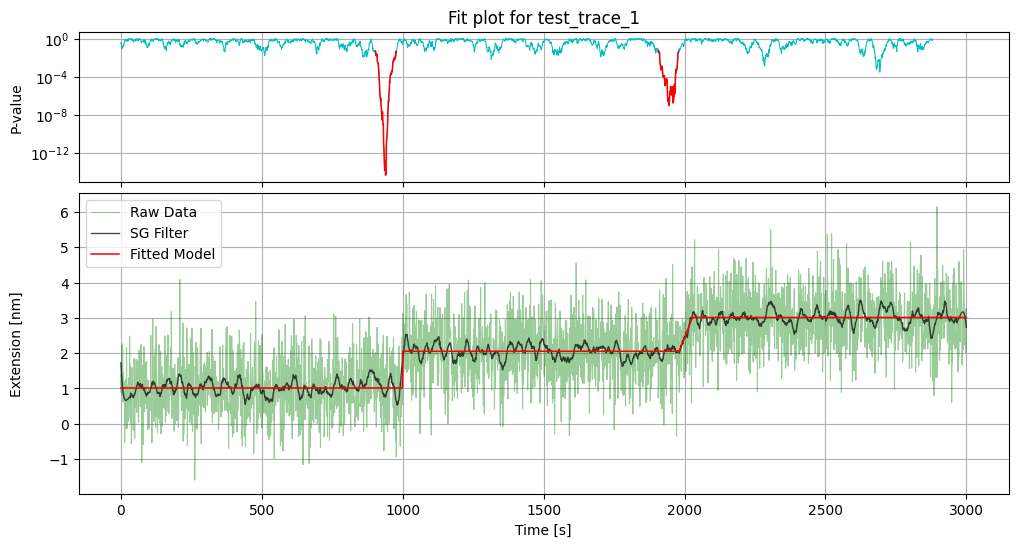

In [14]:
#################################
### CREATE THE SUBPLOT CANVAS ###
#################################

fig, ax = plt.subplots(2, sharex=True,
           gridspec_kw={'hspace': 0.05,
                        'height_ratios': [1, 2]})

###################################################################
### PLOTTING MATERIALS TO AID THE USERS EYES IN JUDGING RESULTS ###
###################################################################

resmask = np.array([],dtype = bool) # Empty Masking Arr

#############################
### PLOTTING THE P-VALUES ###
#############################

# Plots a continuous curve of the p-values from the t-test at each data point and then overlays color-coded curves for regions containing steps

# plot the pvalues
p_t = np.linspace(0,len(pvalue),len(pvalue))
ax[0].semilogy(p_t,pvalue, color = 'c', linewidth = 0.75) # Plots the p-values

for r in regions[:]: # Loops through the step regions but doesn't out steps that don't pass threshold size
     ax[0].semilogy(time_trace[slice(*r)], pvalue[slice(*r)],linewidth= 1.1, color = 'r')
    
for r in regions[:][resmask]: # Loops through the step regions but masks out steps that don't pass threshold size
     ax[0].semilogy(time_trace[slice(*r)], pvalue[slice(*r)],linewidth= 1.1, color = 'b')

#########################################
### PLOT THE FITTED MODEL AND RAW DATA ##
#########################################

# raw trace
ax[1].plot(time_trace, trace, color = 'g', alpha = 0.4, lw = 0.8, label = 'Raw Data') # Plots raw data for visual aid in background

# filtered trace plot
savgo = savgol_filter(trace, window_length, 4)
ax[1].plot(time_trace, savgo, color = 'k', alpha = 0.7, ls = '-', lw = 1, label = 'SG Filter')

# fit output
ax[1].plot(time_trace, trace + output.residual,color = 'r',linewidth = 1.1, label = 'Fitted Model')

#############################
### BASIC PLOT PARAMETERS ###
#############################

ax[0].set_ylabel("P-value")
ax[1].set_ylabel(r"Extension [nm]")
ax[1].set_xlabel("Time [s]")
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_title(f'Fit plot for {tracename}')
# ax[1].set_xlim(2000,2500)
fig.align_labels()
fig.set_size_inches(12,6)
fig.savefig(f'{tracename}_fit.png',dpi=300)
plt.show()

$\textbf{Fig 4.}$ (Top) P values colored by the regions that correspond to a step. (Bottom) `Lmfit` fitted steps (red), smoothed trace (black).

### Save all results (steps and dwell info)

In [15]:
# remove the 'c' parameter
params_filt=output.params.copy()
del params_filt['c']

In [16]:
# create dataframe from fit parameters
df_values = pd.DataFrame([params_filt.valuesdict()])
df_values.index = ['fit_1']
df_values.head()

,s0_amplitude,s0_center,s0_sigma,s1_amplitude,s1_center,s1_sigma
fit_1,1.038416,999.562592,0.020562,0.957987,2004.785963,46.255101


In [17]:
# output the lmfit fit parameters to a csv file
df_values.to_csv(f'{tracename}_lmfit_params.csv')

In [18]:
# save the fitted output
np.savetxt(f'{tracename}_fit_output.dat',trace+output.residual, header=f' fit results for {tracename}')

#### Let's get the steps and dwells' info

In [19]:
df_values.head()

,s0_amplitude,s0_center,s0_sigma,s1_amplitude,s1_center,s1_sigma
fit_1,1.038416,999.562592,0.020562,0.957987,2004.785963,46.255101


In [20]:
# get the data values only
row = df_values.iloc[0]

In [21]:
# these are the step heights
z_values = [row[f's{i}_amplitude'] for i in range(count)]

In [22]:
z_values

[1.038415860624139, 0.9579872707817197]

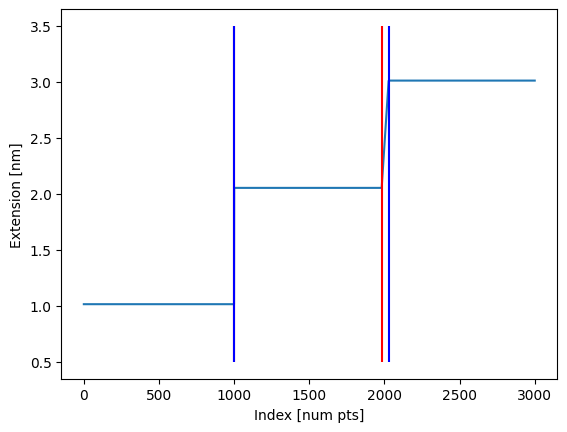

In [23]:
# plot the steps, start end positions and so on
plt.plot(time_trace,trace+output.residual)
[plt.vlines(df_values[f's{i}_center'].iloc[0]-df_values[f's{i}_sigma'].iloc[0]/2,0.5,3.5,'r', label = 'step_starts') for i in range(count)]
[plt.vlines(df_values[f's{i}_center'].iloc[0]+df_values[f's{i}_sigma'].iloc[0]/2,0.5,3.5,'b', label = 'step_ends') for i in range(count)]
plt.ylabel('Extension [nm]')
plt.xlabel('Index [num pts]')
plt.show()

$\textbf{Fig 5.}$ Above, red lines denote step start positions, blue lines denote step end locations.

__Calculation of other parameters__

In [24]:
# easy way to get the step start indices
step_start_idx = [(row[f's{i}_center'] - row[f's{i}_sigma'] / 2) for i in range(count)]
step_start_idx

[999.5523105255984, 1981.658412165224]

In [25]:
# same with the step end indices
step_end_idx = [(row[f's{i}_center'] + row[f's{i}_sigma'] / 2) for i in range(count)]
step_end_idx

[999.572872821376, 2027.9135132390593]

In [26]:
# how long a step took
step_widths = [row[f's{i}_sigma'] for i in range(count)]
step_widths

[0.020562295777678628, 46.255101073835434]

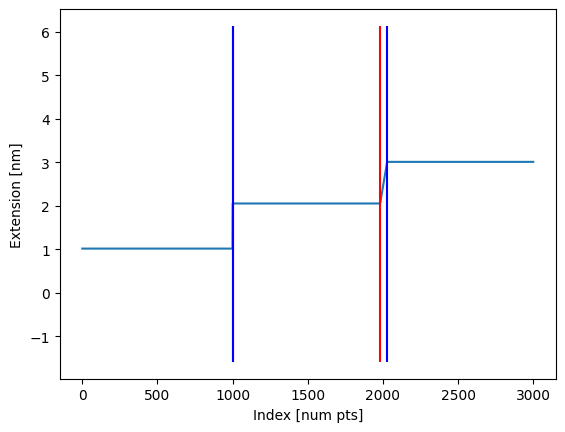

In [27]:
# plot the steps, start end positions and so on
plt.plot(time_trace,trace+output.residual)
[plt.vlines(step_start_idx[i],trace.min(),trace.max(),'r', label = 'step_starts') for i in range(count)]
[plt.vlines(step_end_idx[i],trace.min(),trace.max(),'b', label = 'step_ends') for i in range(count)]
plt.ylabel('Extension [nm]')
plt.xlabel('Index [num pts]')
plt.show()

$\textbf{Fig 6.}$ Replotted to ensure everything is being calculated correctly, compare with $\textbf{Fig 5.}$

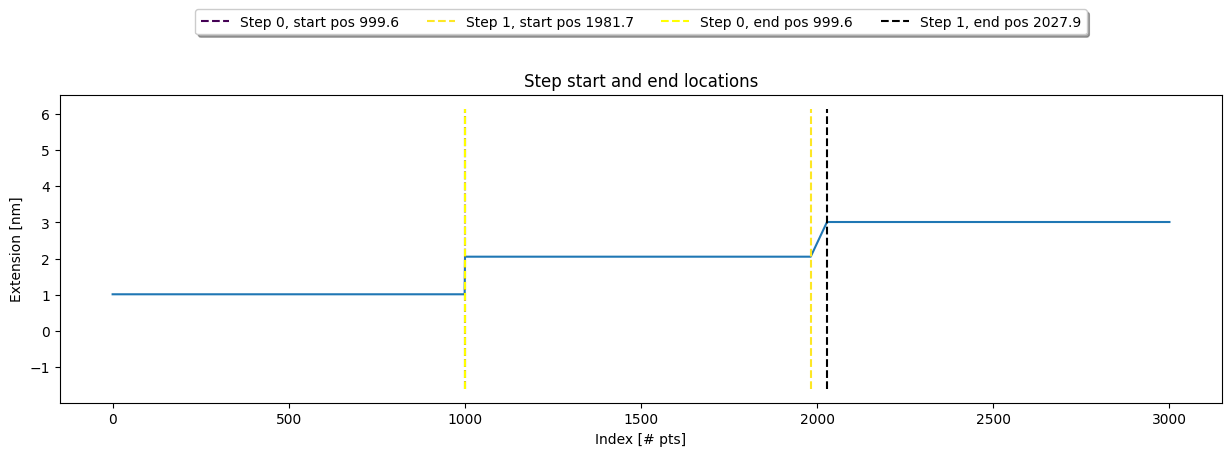

In [28]:
# plot the steps, start end positions and so on
# I am colorblind so hopefully these colors make sense to you

plt.figure(figsize=(15,4))
plt.title('Step start and end locations')
plt.plot(time_trace,trace+output.residual)
[plt.vlines(step_start_idx[i], trace.min(),trace.max(), linestyles='dashed', colors = cm.viridis(i / max(count-1, 1)), 
            label = f'Step {i}, start pos {step_start_idx[i]:.1f}') for i in range(count)]
[plt.vlines(step_end_idx[i], trace.min(),trace.max(), linestyles='dashed', colors = cm.gnuplot_r(i / max(count-1, 1)), 
            label = f'Step {i}, end pos {step_end_idx[i]:.1f}') for i in range(count)]

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
plt.ylabel('Extension [nm]')
plt.xlabel('Index [# pts]')
plt.show()

$\textbf{Fig 7.}$ Similar plot to $\textbf{Fig 5.}$ and $\textbf{Fig 6.}$, overlayed by step start and end indices. Notice how the location of the step was captured correctly as the center of the steps.

Use your frame rate to get results in times rather than just indices.

In [29]:
# declare an empty list, we will keep adding dwells to it below
dwell_widths = []

# num data points
n = len(trace)

# calculate the dwells
if count == 0:
    dwell_widths.append(n)
else:
    # first dwell: from start to first step start
    dwell_widths.append(step_start_idx[0])

    # middle dwells: from end of step i-1 to start of step i
    for i in range(1, count):
        dwell_widths.append(step_start_idx[i] - step_end_idx[i-1])

    # last dwell: from end of last step to end of trace
    dwell_widths.append(n - step_end_idx[-1])

# sanity check
if any(dw < 0 for dw in dwell_widths):
    raise ValueError("Computed negative dwell width(s); check step indices ordering/overlap.")

In [30]:
dwell_widths

[999.5523105255984, 982.085539343848, 972.0864867609407]

__center of the dwells__

In [31]:
step_start_idx = np.asarray(step_start_idx)
step_end_idx   = np.asarray(step_end_idx)

n = len(trace)

if step_start_idx.size == 0:
    dwell_locations = np.array([n / 2.0])
else:
    first  = np.array([step_start_idx[0] / 2.0])
    middle = (step_end_idx[:-1] + step_start_idx[1:]) / 2.0
    last   = np.array([(step_end_idx[-1] + n) / 2.0])
    dwell_locations = np.concatenate([first, middle, last])

In [32]:
dl_int=dwell_locations.astype(int)
dl_int

array([ 499, 1490, 2513])

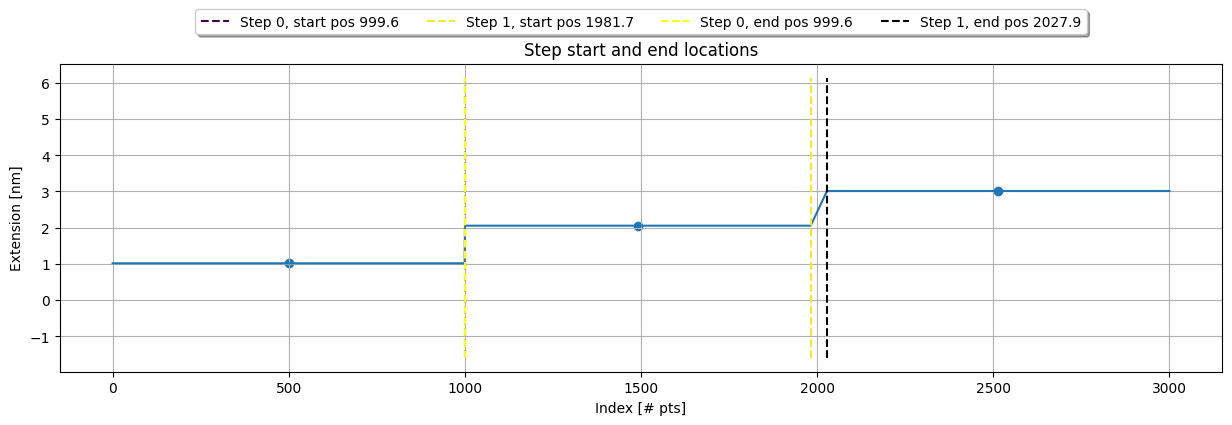

In [33]:
# plot everything
plt.figure(figsize=(15,4))
plt.title('Step start and end locations')
plt.plot(time_trace,trace+output.residual)
[plt.vlines(row[f's{i}_center'] - row[f's{i}_sigma'] / 2, trace.min(),trace.max(), linestyles='dashed',colors = cm.viridis(i / max(count-1, 1)), 
            label = f'Step {i}, start pos {step_start_idx[i]:.1f}') for i in range(count)]
[plt.vlines(row[f's{i}_center'] + row[f's{i}_sigma'] / 2, trace.min(),trace.max(), linestyles='dashed', colors = cm.gnuplot_r(i / max(count-1, 1)), 
            label = f'Step {i}, end pos {step_end_idx[i]:.1f}') for i in range(count)]

# dwell approx locations in z (fix this to also add the residuals so it lands exactly on the horizontal line)
dwell_z = [(trace+output.residual)[vals] for i,vals in enumerate(dl_int)]
plt.scatter(dwell_locations,dwell_z)

# uncomment below to zoom into a particular region to check the values
# plt.xlim(0,400)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=5, fancybox=True, shadow=True)
plt.ylabel('Extension [nm]')
plt.xlabel('Index [# pts]')
plt.grid()
plt.show()

$\textbf{Fig 8.}$ Similar plot to $\textbf{Fig 7.}$ but overlaying the center of the dwells with filled in circles.

__So we now have all the parameters we want. These are__

In [34]:
step_start_idx

array([ 999.55231053, 1981.65841217])

We just want the first step starting z position. The rest can be gotten from lmfit output

In [35]:
step_start_index = step_start_idx.astype(int)
step_start_first = (trace+output.residual)[step_start_index][0]
step_start_first

1.015472540335733

In [36]:
# all step start z positions are given by 
dwell_z_all = ([step_start_first] + list(step_start_first + np.cumsum(z_values)))

step_start_z = dwell_z_all[:-1]
step_start_z

[1.015472540335733, 2.053888400959872]

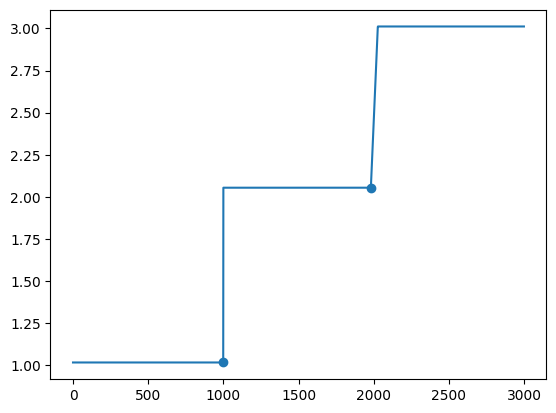

In [37]:
plt.plot(trace+output.residual)
plt.scatter(step_start_idx,step_start_z)
plt.show()

$\textbf{Fig 9.}$ Where steps begin.

Step end calc, both indices and z values

In [38]:
step_end_idx

array([ 999.57287282, 2027.91351324])

In [39]:
step_end_z = dwell_z_all[1::]
step_end_z

[2.053888400959872, 3.0118756717415915]

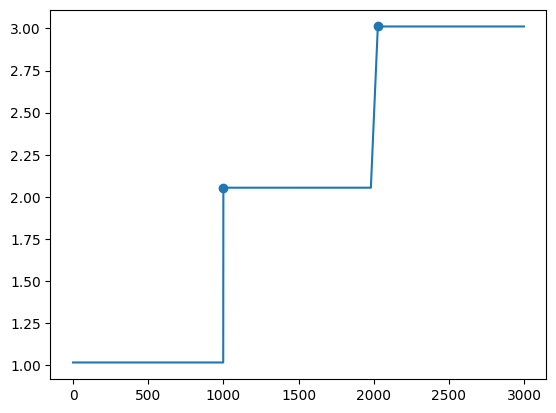

In [40]:
plt.plot(trace+output.residual)
plt.scatter(step_end_idx,step_end_z)
plt.show()

$\textbf{Fig 10.}$ Where steps end.

__Dwell info calculations__

In [41]:
dwell_widths

[999.5523105255984, 982.085539343848, 972.0864867609407]

In [42]:
# dwell location index
dl_int

array([ 499, 1490, 2513])

Other parameters may be computed as desired from these

In [43]:
# step widths can be computed as
step_widths = (step_end_idx-step_start_idx)

In [44]:
step_widths

array([2.05622958e-02, 4.62551011e+01])

We also have the step heights recorded as `s*_amplitude`

In [45]:
step_heights = [(row[f's{i}_amplitude']) for i in range(count)]
step_heights

[1.038415860624139, 0.9579872707817197]

In [46]:
# rate calculation is then straightforward
step_rates = step_heights/step_widths
step_rates

array([5.0500969e+01, 2.0710954e-02])

#### Final results table

results are organized as

In [47]:
res_df = pd.DataFrame({
    'step_start_idx' : pd.Series(step_start_idx),
    'step_start_z' : pd.Series(step_start_z),
    'step_end_idx' : pd.Series(step_end_idx),
    'step_end_z' : pd.Series(step_end_z),
    'step_widths' : pd.Series(step_widths),
    'step_height' : pd.Series(step_heights),
    'step_rate' : pd.Series(step_rates),
    'dwell_widths' : pd.Series(dwell_widths),
    'dwell_center_x' : pd.Series(dwell_locations),
    'dwell_center_z' : pd.Series(dwell_z)
})

# save all computed parameters as a csv file
res_df.to_csv(f'{tracename}_fit_results.csv')

res_df

,step_start_idx,step_start_z,step_end_idx,step_end_z,step_widths,step_height,step_rate,dwell_widths,dwell_center_x,dwell_center_z
0,999.552311,1.015473,999.572873,2.053888,0.020562,1.038416,50.500969,999.552311,499.776155,1.015473
1,1981.658412,2.053888,2027.913513,3.011876,46.255101,0.957987,0.020711,982.085539,1490.615642,2.053888
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,972.086487,2513.956757,3.011876


Save all fit output parameters

In [48]:
with open(f"{tracename}_fit_report.txt", "w") as f:
    f.write(output.fit_report())